<a href="https://colab.research.google.com/github/Arijit-datascience/CIFAR10_Image_Recognition/blob/main/CIFAR10_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Advanced Convolutions

A. Target

change the code such that it uses GPU
change the architecture to C1C2C3C40 (basically 3 MPs)
total RF must be more than 44
one of the layers must use Depthwise Separable Convolution
one of the layers must use Dilated Convolution
use GAP (compulsory):- add FC after GAP to target #of classes (optional)
achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M.
B. Results

Parameters: 815,200
Best Training Accuracy in 20 epochs: 87.72%
Best Test Accuracy in 20 epochs: 85.09 %
Total RF reached: 76*76 at the end of Conv block 4
C. Analysis

Model meets all the mentioned targets. I have used the Depthwise seprable con and dialted kernel in the conv block 3. Also, As train test gap was coming more in earlier versions, I have used the horizontal flip and random rotations to act as regulaizer and reduce the train test gap. Code is modularized and uploaded as package in git repo.

In [1]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, OneCycleLR

import os
import numpy as np

In [2]:
!git clone https://github.com/Arijit-datascience/CIFAR10_Image_Recognition
!pip install albumentations==1.0.0

Cloning into 'CIFAR10_Image_Recognition'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 223 (delta 109), reused 131 (delta 51), pack-reused 0
Receiving objects: 100% (223/223), 1.19 MiB | 9.87 MiB/s, done.
Resolving deltas: 100% (109/109), done.
     |████████████████████████████████| 102kB 5.1MB/s 
     |████████████████████████████████| 38.2MB 76kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
from CIFAR10_Image_Recognition.dataset import dataset as dataset
from CIFAR10_Image_Recognition.models import model as models
from CIFAR10_Image_Recognition.models import train as train
from CIFAR10_Image_Recognition.models import test as test
from CIFAR10_Image_Recognition.utils import plots as utils

In [4]:
  norm_mean,norm_std = dataset.cifar10_mean_std()
  train_transform, test_transform = dataset.get_transforms(norm_mean,norm_std)

  # Extract and transform the data
  train_set,test_set = dataset.get_datasets(train_transform,test_transform)

  # Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  classes = train_set.classes

  # Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
  train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(0.492, 0.483, 0.447) (0.247, 0.243, 0.262)
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


## Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


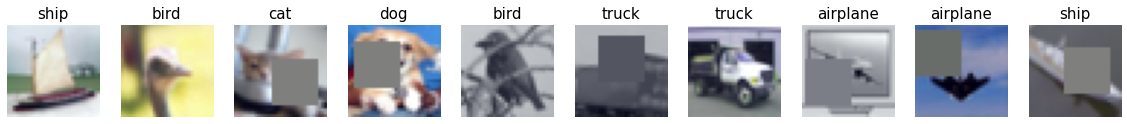

In [5]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

In [6]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## Import Model and show model summary

In [7]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           2,080
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

## Train and Test

In [8]:
def main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, l1_factor):
  train_loss_values = []
  test_loss_values = []
  train_acc_values = []
  test_acc_values = []

  for epoch in range(1, EPOCH + 1):
      print('\nEpoch {} : '.format(epoch))
      # train the model
      train_loss, train_acc = train.train(model, device, train_loader, optimizer, scheduler, epoch, l1_factor)
      test_loss, test_acc, test_pred, target_pred, target_data = test.test(model, device, test_loader)

      train_loss_values.append(train_loss)
      test_loss_values.append(test_loss)

      train_acc_values.append(train_acc)
      test_acc_values.append(test_acc)

  return train_loss_values, test_loss_values, train_acc_values, test_acc_values, test_pred, target_pred, target_data

In [10]:
if __name__=='__main__':

  EPOCH = 100
  batch_size = 256
  l1_factor = 0
  l2_factor = 0.0001
  lr_value = 0.01

  cuda = torch.cuda.is_available()
  device = torch.device("cuda" if cuda else "cpu")

  seed_everything(1)

  model = models.Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr_value, weight_decay=l2_factor)
  scheduler = OneCycleLR(optimizer, max_lr=lr_value,epochs=EPOCH,steps_per_epoch=len(train_loader))
  
  print("------------------------------------------")
  train_loss, test_loss, train_acc, test_acc, test_pred, target_pred, target_data = main(EPOCH, model, device, train_loader, test_loader, optimizer, scheduler, l1_factor)

------------------------------------------

Epoch 1 : 
Train set: Average loss: 1.9867, Accuracy: 20.23

Test set: Average loss: 1.913, Accuracy: 26.57

Epoch 2 : 
Train set: Average loss: 1.7566, Accuracy: 28.19

Test set: Average loss: 1.738, Accuracy: 35.44

Epoch 3 : 
Train set: Average loss: 1.7023, Accuracy: 34.42

Test set: Average loss: 1.581, Accuracy: 40.94

Epoch 4 : 
Train set: Average loss: 1.5891, Accuracy: 38.13

Test set: Average loss: 1.480, Accuracy: 44.66

Epoch 5 : 
Train set: Average loss: 1.6538, Accuracy: 42.70

Test set: Average loss: 1.392, Accuracy: 48.71

Epoch 6 : 
Train set: Average loss: 1.3769, Accuracy: 46.98

Test set: Average loss: 1.209, Accuracy: 55.35

Epoch 7 : 
Train set: Average loss: 1.2010, Accuracy: 51.84

Test set: Average loss: 1.109, Accuracy: 59.67

Epoch 8 : 
Train set: Average loss: 1.2966, Accuracy: 55.50

Test set: Average loss: 1.080, Accuracy: 61.88

Epoch 9 : 
Train set: Average loss: 1.1467, Accuracy: 57.85

Test set: Average loss:

## Validation accuracy and Loss curves

NameError: ignored

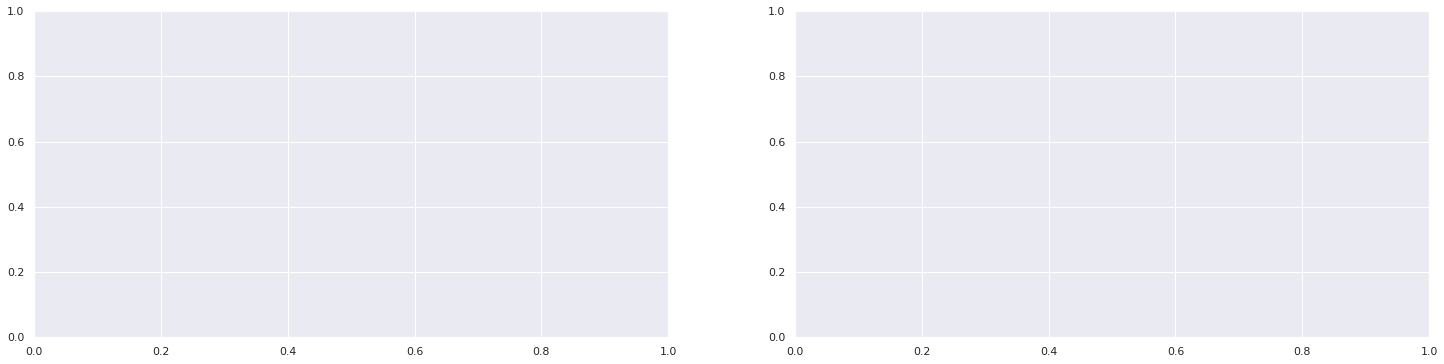

In [12]:
utils.valid_accuracy_loss_plots(train_loss, train_acc, test_loss, test_acc)

## Display misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

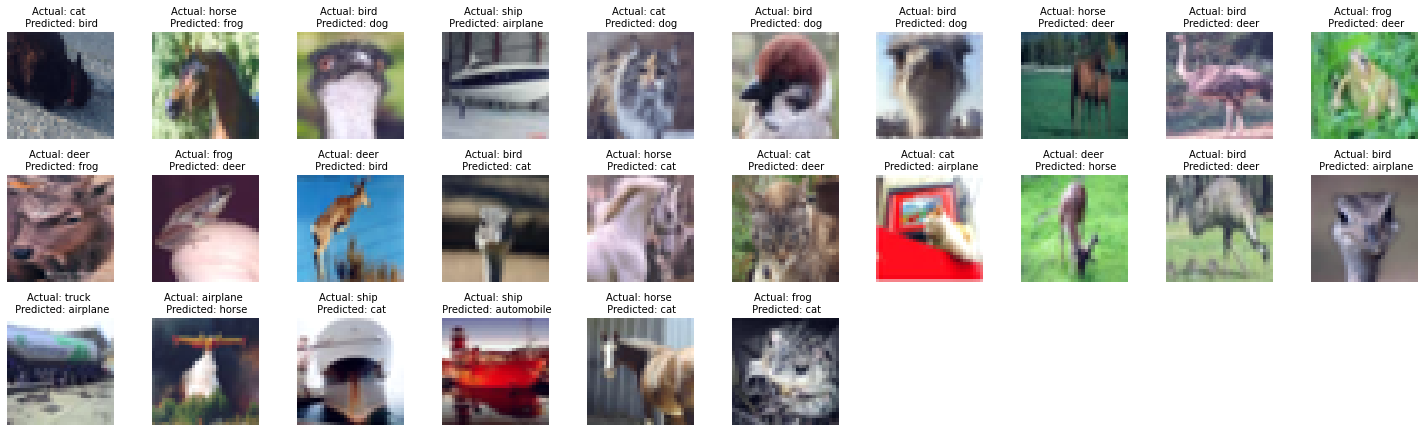

In [12]:
utils.show_misclassified_images(model, classes, test_loader, num_of_images = 25)